## **CNN: Text Modality using GloVe**

Se usa una arquitectura que consiste en redes neuronales convolucionales. En el paper se menciona el uso de un modelo word2vec pre-entrenado discutido en otro paper, como no se tiene acceso a este modelo se prefirió optar por otras alternativas similares pero manteniendo el uso de word2vec con 300 dimensiones.

In [1]:
import os

# Configurar TensorFlow para usar menos memoria de GPU
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import tensorflow.keras
import pandas as pd
import re

2025-11-26 04:53:09.500858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import nltk
from nltk.corpus import stopwords
import random
import torch
from torch.utils.data.dataset import random_split
from random import sample
from nltk.tokenize import word_tokenize
from collections import namedtuple

In [4]:
import numpy as np
import gensim
from gensim.models import Word2Vec

In [5]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

### **Preprocesamiento**
"we preprocess them by removing stop words, non-ASCII charachters, numbers, URLs and hashtag signs. we also replace all punctuation marks with white spaces"

In [6]:
df_text = pd.read_csv('/home/jacruz/crisis/data/crisis_texts_dataset.csv')
df_text.head()

,tweet_id,text_info,text_info_conf,tweet_text
0,917791044158185473,informative,1.0000,RT @Gizmodo: Wildfires raging through Northern...
1,917791130590183424,informative,1.0000,PHOTOS: Deadly wildfires rage in California ht...
2,917791291823591425,informative,0.6813,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...
3,917792092100988929,informative,0.6727,RT @TIME: California's raging wildfires as you...
4,917792147700465664,informative,0.7143,Wildfires Threaten Californiaâ€™s First Legal ...


In [7]:
# Para el manejo de stopwords

#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['rt', 'RT'])

print(stop_words)


{'until', 's', 'those', "wasn't", 'will', 'which', 'haven', "i've", 'an', 'on', "shouldn't", "i'm", "won't", 'yourself', 'itself', 'aren', "he'll", "hadn't", 'didn', 'himself', 'doesn', 'here', "aren't", 'this', 'me', 'hadn', 'because', 'couldn', 'mustn', 'a', 'down', 'with', 'as', 'once', 'such', "weren't", "we'll", "we're", "haven't", 'ma', 'and', 'theirs', "we've", 'it', 'our', 'been', 'while', 'so', 'more', "needn't", 'or', "it'd", 'if', 'them', "doesn't", "didn't", 'from', 'but', 'wouldn', 'does', 'too', 'who', 'how', 'other', "you've", "mightn't", 'over', 'is', 'has', 'out', "hasn't", 'the', 'these', 'o', 'needn', 'again', 'don', 'before', 'just', "you're", 'are', 'for', 'i', 'during', 'm', 'y', 'shouldn', 'under', 'off', 'being', 'isn', 'there', 'won', 'each', 'ours', 'why', 'herself', 'myself', 'hers', "she's", 'my', 'all', 'nor', 'RT', 'only', 'into', 've', 'yours', 'now', 'him', 'further', 'his', 'hasn', "they've", 'of', 'by', 'be', "she'll", 'their', 'than', "they'd", 'throu

In [8]:
def clean_text(text):
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar caracteres no ASCII
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Reemplazar signos de puntuación con espacios
    text = re.sub(r'[^\w\s]', ' ', text)
    # Convertir a minúsculas y eliminar stopwords
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
    return text

In [9]:
df_text['clean_text'] = df_text['tweet_text'].apply(clean_text)
df_text.head(100)

,tweet_id,text_info,text_info_conf,tweet_text,clean_text
0,917791044158185473,informative,1.0000,RT @Gizmodo: Wildfires raging through Northern...,gizmodo wildfires raging northern california t...
1,917791130590183424,informative,1.0000,PHOTOS: Deadly wildfires rage in California ht...,photos deadly wildfires rage california
2,917791291823591425,informative,0.6813,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,cal_oes pls share capturing wildfire response ...
3,917792092100988929,informative,0.6727,RT @TIME: California's raging wildfires as you...,time california raging wildfires never seen
4,917792147700465664,informative,0.7143,Wildfires Threaten Californiaâ€™s First Legal ...,wildfires threaten californias first legal can...
...,...,...,...,...,...
95,917833987824979968,informative,0.6783,Satellite image of California last night. Thos...,satellite image california last night arent li...
96,917834588814155776,informative,0.6854,RT @AuroraWorldView: Deadly #California #wildf...,auroraworldview deadly california wildfires fo...
97,917834628290920448,informative,0.6667,Fire swept through Northern California early M...,fire swept northern california early monday mo...
98,917835067069788162,informative,1.0000,"Couple, ages 100 and 98, die in CaliforniaÂ wi...",couple ages die california wildfire


In [10]:
# Muestra aleatoria de textos limpios

random.sample(list(df_text['clean_text']), 10)

['houston hobby airport shutdown notice hurricaneharvey',
 'deck republikkklans rnc gop voted disasters harvey irma katrina thank democrat',
 'fire destroy couple married years die side side',
 'utilities delayed effort map power line wildfire risk facing california probe',
 'numbers explain hurricane maria devastating toll puerto rico',
 'come iga nhs selling baked goods support hurricane relief puerto rico',
 'relocate young kids pre disaster prep hysteria period house feed clothe clean safe harvey irma fema',
 'lets rebuild better smarter cuomo says thats puerto rico',
 'ianbremmer little different yesterday irma',
 'jennifer lopez personally affected hurricane maria']

In [11]:

dataset = tuple(
    (row['text_info'], row['clean_text'])
    for _, row in df_text.iterrows() 
)
dataset[:5]

(('informative', 'gizmodo wildfires raging northern california terrifying'),
 ('informative', 'photos deadly wildfires rage california'),
 ('informative',
  'cal_oes pls share capturing wildfire response recovery info'),
 ('informative', 'time california raging wildfires never seen'),
 ('informative',
  'wildfires threaten californias first legal cannabis harvest'))

In [12]:
# Proporciones
train_ratio = 0.75
dev_ratio = 0.15
test_ratio = 0.15

# Longitudes
train_len = int(len(dataset) * train_ratio)
dev_len = int(len(dataset) * dev_ratio)
test_len = len(dataset) - train_len - dev_len  # para evitar problemas de redondeo

# Tamaño total del dataset y su distribución de clases
print(f"Tamaño total del dataset: {len(dataset)}")
total_informative = sum(1 for label, _ in dataset if label == 'informative')
total_non_informative = len(dataset) - total_informative
print(f"  Informative: {total_informative} ({total_informative / len(dataset) * 100:.2f}%)")
print(f"  Non-informative: {total_non_informative} ({total_non_informative / len(dataset) * 100:.2f}%)")

# Dividimos el dataset
train_split, dev_split, test_split = random_split(dataset, [train_len, dev_len, test_len])

# Mostramos los tamaños de cada split y su distribución de clases
print(f"\nTamaño del set de entrenamiento: {len(train_split)}")
train_informative = sum(1 for label, _ in train_split if label == 'informative')
train_non_informative = len(train_split) - train_informative
print(f"  Informative: {train_informative} ({train_informative / len(train_split) * 100:.2f}%)")
print(f"  Non-informative: {train_non_informative} ({train_non_informative / len(train_split) * 100:.2f}%)")

print(f"Tamaño del set de validación: {len(dev_split)}")
dev_informative = sum(1 for label, _ in dev_split if label == 'informative')
dev_non_informative = len(dev_split) - dev_informative
print(f"  Informative: {dev_informative} ({dev_informative / len(dev_split) * 100:.2f}%)")
print(f"  Non-informative: {dev_non_informative} ({dev_non_informative / len(dev_split) * 100:.2f}%)")

print(f"Tamaño del set de prueba: {len(test_split)}")
test_informative = sum(1 for label, _ in test_split if label == 'informative')
test_non_informative = len(test_split) - test_informative
print(f"  Informative: {test_informative} ({test_informative / len(test_split) * 100:.2f}%)")
print(f"  Non-informative: {test_non_informative} ({test_non_informative / len(test_split) * 100:.2f}%)")

# Mostramos algunos ejemplos
print("\nEjemplos del set de entrenamiento:")
for example in sample(list(train_split), 3):
    print(example)
print("\nEjemplos del set de validación:")
for example in sample(list(dev_split), 3):
    print(example)
print("\nEjemplos del set de prueba:")
for example in sample(list(test_split), 3):
    print(example)

Tamaño total del dataset: 16058
  Informative: 11503 (71.63%)
  Non-informative: 4555 (28.37%)

Tamaño del set de entrenamiento: 12043
  Informative: 8620 (71.58%)
  Non-informative: 3423 (28.42%)
Tamaño del set de validación: 2408
  Informative: 1723 (71.55%)
  Non-informative: 685 (28.45%)
Tamaño del set de prueba: 1607
  Informative: 1160 (72.18%)
  Non-informative: 447 (27.82%)

Ejemplos del set de entrenamiento:
('not_informative', 'rouhani vs ahmadinejad pictures speak volume iran earthquake')
('informative', 'texas school districts preparing take students displaced byharvey')
('informative', 'seattledjc puerto rico bonds sink bailout idea denied')

Ejemplos del set de validación:
('informative', 'yall going pretend wasnt earthquake mexico talk')
('informative', 'skynews people repent late mexico earthquake newzealand hurricane maria')
('informative', 'harvey destroyed houstons carsthis program giving away bikes replace')

Ejemplos del set de prueba:
('informative', 'msn island b

In [13]:
# Tokenización
# nltk.download('punkt_tab')

In [14]:
document = namedtuple('tweet', ['text', 'label'])

tokenized_train_set = [document(text=word_tokenize(d[1]), label=d[0]) for d in train_split]
train_set = pd.DataFrame(tokenized_train_set)

tokenized_dev_set = [document(text=word_tokenize(d[1]), label=d[0]) for d in dev_split]
dev_set = pd.DataFrame(tokenized_dev_set)

tokenized_test_set = [document(text=word_tokenize(d[1]), label=d[0]) for d in test_split]
test_set = pd.DataFrame(tokenized_test_set)

test_set.head()


,text,label
0,"[trump, praises, first, responders, fema, head...",informative
1,"[lot, flood, damaged, cars, expected, hit, mar...",informative
2,"[roundup, bitcoin, blowing, california, fire, ...",not_informative
3,"[bts_twt, love, puerto, rico, biutiful, cute]",not_informative
4,"[tested, hurr, irma, vw, atlas, fresh, mycardata]",informative


In [15]:
# Convertir etiquetas a numéricas
label_mapping = {'informative': 1, 'not_informative': 0}

train_set['label'] = train_set['label'].map(label_mapping)
dev_set['label'] = dev_set['label'].map(label_mapping)
test_set['label'] = test_set['label'].map(label_mapping)


### **Uso de GloVe**
En el paper se usa un modelo que no es de acceso público, esta versión usa GloVe que también es pre-entrenado con Wikipedia, siendo de 300 dimensiones. Contiene aproximadamente 400K palabras. Se nota una diferencia debido a que el usado en el paper fue pre-entrenado con 364M de tweets de desastres

In [16]:
def load_glove_embeddings(glove_path, embedding_dim=300):
    """
    Carga los embeddings pre-entrenados de GloVe
    """
    print("Cargando embeddings GloVe...")
    embeddings_index = {}
    
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    print(f'Se cargaron {len(embeddings_index)} vectores de palabras.')
    return embeddings_index

In [17]:
# Descargar y cargar GloVe (versión de 300 dimensiones)
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [18]:
# Cargar los embeddings GloVe
glove_path = 'glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim=300)

Cargando embeddings GloVe...
Se cargaron 400000 vectores de palabras.


In [19]:
def create_embedding_matrix(tokenizer, glove_embeddings, embedding_dim=300, vocab_limit=50000):
    """
    Crea la matriz de embedding usando GloVe
    """
    vocab_size = min(len(tokenizer.word_index) + 1, vocab_limit)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    words_not_found = []
    words_found = 0
    
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size:
            continue
        if word in glove_embeddings:
            # Palabra encontrada en GloVe
            embedding_matrix[i] = glove_embeddings[word]
            words_found += 1
        else:
            # Palabra no encontrada - usar vector aleatorio
            embedding_matrix[i] = np.random.normal(scale=0.1, size=(embedding_dim,))
            words_not_found.append(word)
    
    print(f"Palabras no encontradas en GloVe: {len(words_not_found)}")
    if len(words_not_found) > 0:
        print(f"Ejemplos de palabras no encontradas: {words_not_found[:5]}")
    
    return embedding_matrix

### **Arquitectura del modelo**

In [20]:
# Jugando con Word2Vec
sentences = train_set['text'].tolist()  # Se pasa a lista de listas de tokens
w2v = Word2Vec(sentences, vector_size=300, window=5, min_count=5, workers=4)

vocab = list(w2v.wv.key_to_index.keys())

palabra_a_buscar = 'mexico'
print(f"El vocabulario tiene {len(vocab)} palabras")
print(f"Algunas palabras aleatorias del vocabulario: {sample(vocab, 10)}")

# Buscar palabras similares
w2v.wv.most_similar(palabra_a_buscar)
print(f"Palabras más similares a '{palabra_a_buscar}': {w2v.wv.most_similar(palabra_a_buscar)}")

# Similitud entre dos palabras
palabra1 = 'help'
palabra2 = 'support'
similarity = w2v.wv.similarity(palabra1, palabra2)
print(f"La similitud entre '{palabra1}' y '{palabra2}' es: {similarity}")

El vocabulario tiene 2998 palabras
Algunas palabras aleatorias del vocabulario: ['caicos', 'minute', 'brevard', 'evacuate', 'left', 'clean', 'moka', 'neighborhood', 'band', 'kuwait']
Palabras más similares a 'mexico': [('iran', 0.9985864758491516), ('iraq', 0.9968170523643494), ('city', 0.9965870380401611), ('border', 0.9961965680122375), ('magnitude', 0.995497465133667), ('earthquake', 0.9953389763832092), ('hits', 0.9935663342475891), ('kills', 0.993219256401062), ('rocks', 0.9919459819793701), ('shakes', 0.991885781288147)]
La similitud entre 'help' y 'support' es: 0.9997673630714417


In [21]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
# Construcción del modelo 

class CNN:
    def __init__(self,
                 vocab_size,
                 embedding_matrix,
                 embedding_dim=300,
                 max_seq_len=100,
                 num_classes=2,
                 ):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.num_classes = num_classes
        self.embedding_matrix = embedding_matrix
        self.model = self.build_model()

    def build_model(self):
        input_layer = layers.Input(shape=(self.max_seq_len,))
        x = layers.Embedding(input_dim=self.vocab_size,
                                           output_dim=self.embedding_dim,
                                           weights=[self.embedding_matrix],
                                           input_length=self.max_seq_len,
                                           trainable=False)(input_layer)
        # convoluciones
        conv_blocks = []
        conv1 = layers.Conv1D(filters=100,
                              kernel_size=2,
                              activation='relu',
                              padding='same')(x)
        # Se toma el valor máximo de cada filtro
        pool1 = layers.GlobalMaxPooling1D()(conv1)
        conv_blocks.append(pool1)
        conv2 = layers.Conv1D(filters=150,
                              kernel_size=3,
                              activation='relu',
                              padding='same')(x)
        pool2 = layers.GlobalMaxPooling1D()(conv2)
        conv_blocks.append(pool2)
        conv3 = layers.Conv1D(filters=200,
                              kernel_size=4,
                              activation='relu',
                              padding='same')(x)
        pool3 = layers.GlobalMaxPooling1D()(conv3)
        conv_blocks.append(pool3)

        # concatenar las salidas de las convoluciones
        concat = layers.Concatenate()(conv_blocks)

        # dropout para evitar overfitting apagando neuronas aleatoriamente
        x = layers.Dropout(0.02)(concat)
        
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.02)(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(0.02)(x)

        # capa de salida
        output_layer = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=input_layer, outputs=output_layer)
        return model
    
    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
        return self.model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        early_stopping = [EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )]
        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping])
        return history
    
    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X):
        predictions = self.model.predict(X, verbose=0)
        return predictions

### **Experimento**

In [23]:
# Preparación de los datos para Keras
X_train = [' '.join(tokens) for tokens in train_set['text']]
y_train = train_set['label'].values

X_dev = [' '.join(tokens) for tokens in dev_set['text']]
y_dev = dev_set['label'].values

X_test = [' '.join(tokens) for tokens in test_set['text']]
y_test = test_set['label'].values

# Tokenización con Keras
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

# Convertir a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_dev_seq = tokenizer.texts_to_sequences(X_dev)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Parámetros
vocab_size = min(len(tokenizer.word_index) + 1, 50000)
max_seq_len = 50
embedding_dim = 300

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post')
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_seq_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post')

print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Forma de X_train: {X_train_pad.shape}")
print(f"Forma de X_dev: {X_dev_pad.shape}")
print(f"Forma de X_test: {X_test_pad.shape}")

Tamaño del vocabulario: 18650
Forma de X_train: (12043, 50)
Forma de X_dev: (2408, 50)
Forma de X_test: (1607, 50)


In [24]:
# Crear matriz de embedding
embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings, embedding_dim, vocab_limit=50000)
print(f"Forma de la matriz de embedding: {embedding_matrix.shape}")

Palabras no encontradas en GloVe: 5535
Ejemplos de palabras no encontradas: ['hurricanemaria', 'hurricaneharvey', 'puertorico', 'mexicoearthquake', 'hurricaneirma']
Forma de la matriz de embedding: (18650, 300)


In [25]:
# Instanciar y compilar el modelo
cnn_model = CNN(vocab_size=vocab_size, 
                embedding_matrix=embedding_matrix,
                embedding_dim=embedding_dim,
                max_seq_len=max_seq_len,
                num_classes=2)

model = cnn_model.compile_model()
print("Resumen del modelo:")
model.summary()

# Entrenar el modelo
print("\nIniciando entrenamiento...")
history = cnn_model.train(
    X_train_pad, y_train,
    X_dev_pad, y_dev,
    epochs=1000,
    batch_size=32
)


/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-11-26 04:53:25.684194: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764143605.684212  655410 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1764143605.684446  655410 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1011 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:05:00.0, compute capability: 8.6
2025-11-26 04:53:25.684688: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764143605.684693  655410 gpu_

Resumen del modelo:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 300)   │  5,595,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 100)   │     60,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 150)   │    135,150 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 200)   │    240,200 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 150)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 450)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 450)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    230,912 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │         66 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 6,435,988 (24.55 MB)

 Trainable params: 840,988 (3.21 MB)

 Non-trainable params: 5,595,000 (21.34 MB)


Iniciando entrenamiento...
Epoch 1/1000


2025-11-26 04:53:27.769776: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ff14800b2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-26 04:53:27.769792: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-11-26 04:53:27.769796: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-11-26 04:53:27.812541: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-26 04:53:28.054556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-26 04:53:28.288457: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not 

 88/377 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7403 - loss: 0.5228 

I0000 00:00:1764143617.482690  658768 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7818 - loss: 0.4660

2025-11-26 04:53:43.026544: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 04:53:43.026565: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 04:53:43.026573: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 04:53:43.415590: I external/l

377/377 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8034 - loss: 0.4357 - val_accuracy: 0.8148 - val_loss: 0.4155
Epoch 2/1000
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8540 - loss: 0.3487 - val_accuracy: 0.8090 - val_loss: 0.4135
Epoch 3/1000
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8994 - loss: 0.2496 - val_accuracy: 0.8040 - val_loss: 0.4767
Epoch 4/1000
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9476 - loss: 0.1349 - val_accuracy: 0.8019 - val_loss: 0.5999
Epoch 5/1000
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9647 - loss: 0.0918 - val_accuracy: 0.7816 - val_loss: 0.8052
Epoch 6/1000
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9785 - loss: 0.0614 - val_accuracy: 0.7625 - val_loss: 0.8698
Epoch 7/1000
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9833 - loss: 0.0459 - val_accuracy: 0.7924 - val_loss: 1.0786
Epoch 8/1000
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9873 - loss: 0.0327 - val_accurac

In [26]:
# Evaluar en test set
print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*60)
test_loss, test_accuracy = cnn_model.evaluate(X_test_pad, y_test)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Predicciones
y_pred_proba = cnn_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_proba, axis=1)

# Reporte de clasificación
print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=['Not Informative', 'Informative'],
                          digits=4))


EVALUACIÓN EN CONJUNTO DE PRUEBA


2025-11-26 04:53:55.827167: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 8 bytes spill stores, 8 bytes spill loads



Loss: 0.4252
Accuracy: 0.8108

REPORTE DE CLASIFICACIÓN
                 precision    recall  f1-score   support

Not Informative     0.7849    0.4407    0.5645       447
    Informative     0.8156    0.9534    0.8792      1160

       accuracy                         0.8108      1607
      macro avg     0.8002    0.6971    0.7218      1607
   weighted avg     0.8071    0.8108    0.7916      1607



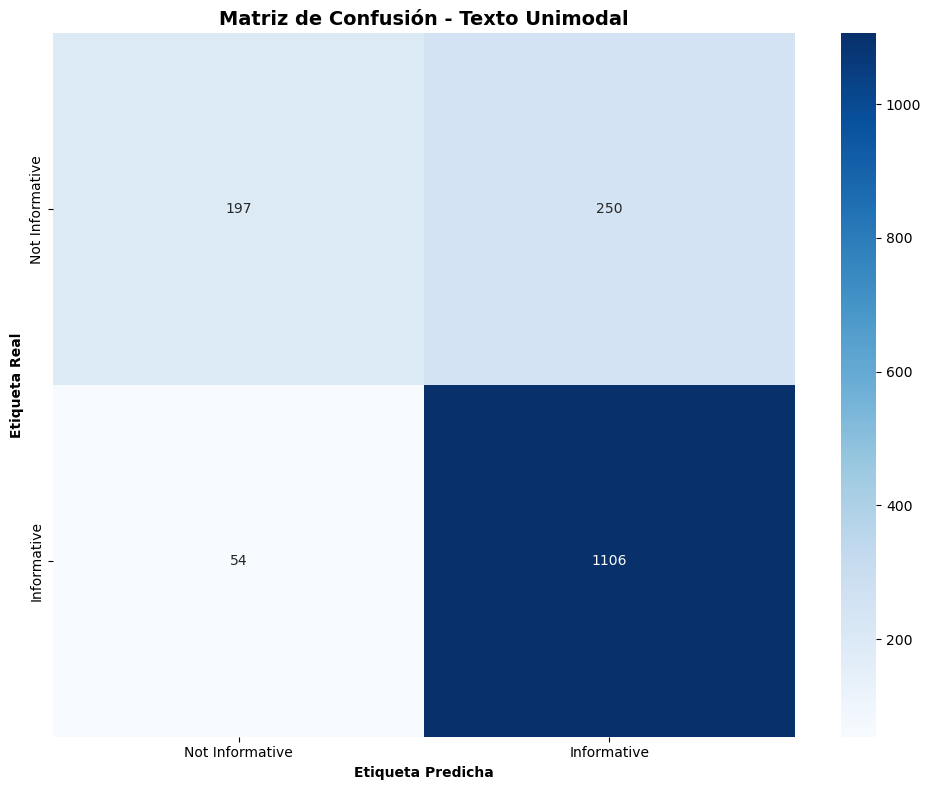

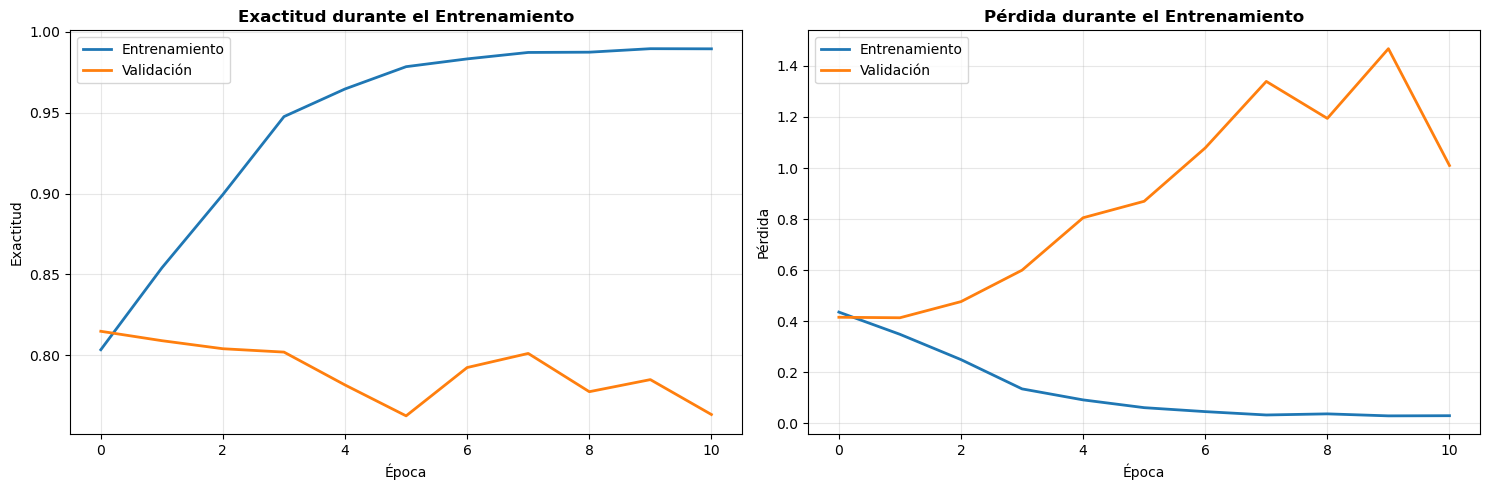

In [27]:
# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Informative', 'Informative'],
            yticklabels=['Not Informative', 'Informative'])
plt.title('Matriz de Confusión - Texto Unimodal', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontweight='bold')
plt.xlabel('Etiqueta Predicha', fontweight='bold')
plt.tight_layout()
plt.show()

# Curvas de aprendizaje
plt.figure(figsize=(15, 5))

# Exactitud
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validación', linewidth=2)
plt.title('Exactitud durante el Entrenamiento', fontsize=12, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()
plt.grid(True, alpha=0.3)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
plt.plot(history.history['val_loss'], label='Validación', linewidth=2)
plt.title('Pérdida durante el Entrenamiento', fontsize=12, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Calcular F1-score de nuestro modelo
our_f1 = f1_score(y_test, y_pred)
print(f"\nNuestro modelo - F1-score: {our_f1:.4f}")

# Estadísticas del modelo
print(f"\nEstadísticas del modelo:")
print(f"- Tamaño del vocabulario: {vocab_size}")
print(f"- Longitud máxima de secuencia: {max_seq_len}")
print(f"- Dimensión de embedding: {embedding_dim}")
print(f"- Épocas entrenadas: {len(history.history['accuracy'])}")
print(f"- Mejor exactitud en validación: {max(history.history['val_accuracy']):.4f}")

# Guardar el modelo si es necesario
model.save('text_unimodal_cnn.keras')
print("\nModelo guardado como 'text_unimodal_cnn.keras'")


Nuestro modelo - F1-score: 0.8792

Estadísticas del modelo:
- Tamaño del vocabulario: 18650
- Longitud máxima de secuencia: 50
- Dimensión de embedding: 300
- Épocas entrenadas: 11
- Mejor exactitud en validación: 0.8148

Modelo guardado como 'text_unimodal_cnn.keras'
